In [7]:
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import matplotlib.cm as pltc
import scipy.io as sio
import networkx as nx
import seaborn as sns
import numpy as np
import skimage
import logging
import cv2
import time
from IPython.display import clear_output
import sys
import numpy

np.set_printoptions(threshold=sys.maxsize)

In [8]:
% matplotlib inline

### Uploading our modules.

In [14]:
import data_preprocessing
import linear_subspaces
import skeletons
import plotting
import opencv
import graphs
import clustering

In [15]:
def load_data(file): return sio.loadmat(file)


dataset = 'all'
video = '3.mp4'
file = '4.mat'

DATASET_DIR = f'../data/{dataset}/'
VIDEO_FILE = f'../data/{dataset}/{video}'
# data = load_data(f'../data/{dataset}/{file}')

In [17]:
FROM_FRAME = 5895
TO_FRAME = 5906

LABELS = np.arange(FROM_FRAME, TO_FRAME + 1)

# Previous code in case above doesn't work on your machine
DATASET_DIR = '../dataset/EurosportAll/'
BASE_FILE = DATASET_DIR + 'girosmallveryslow2'
VIDEO_FILE = BASE_FILE + '.mp4'
FEATURES_FILE = VIDEO_FILE + '_features'
data = load_data(FEATURES_FILE)

In [18]:
skel_data = load_data(f'../data/{dataset}/skel.mat')['skeldata']

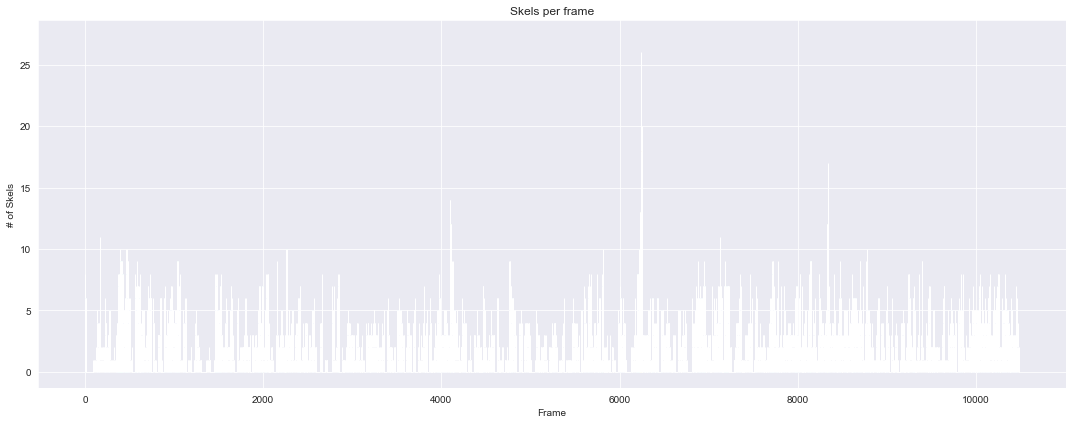

In [19]:
## On JUPYTER colours are not showing well.
## Check HW1 for the cool looking bar plot

def skel_info(data):
    last = int(data[0][-1])
    frames = [i for i in range(last + 1)]
    hist = [0] * (last + 1)
    for i in data[0]:
        hist[int(i)] += 1
    bar_plot(frames, hist, 'Skels per frame', 'Frame', '# of Skels')


def bar_plot(x, y, title, xlabel, ylabel):
    plt.figure(figsize=(15, 6), tight_layout=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    margin = 0.05 * (max(y) - min(y))
    plt.gca().set_ylim([min(y) - margin, max(y) + 2 * margin])
    colours = pltc.turbo(plt.Normalize(min(y), max(y))(y))
    plt.bar(x, y, width=1, align='edge', color=colours)
    plt.show()


skel_info(skel_data)

In [20]:
features, subspace_vectors = data_preprocessing.get_features(data, 'features', FROM_FRAME, TO_FRAME)

Data has got 10482 512-sized objects.


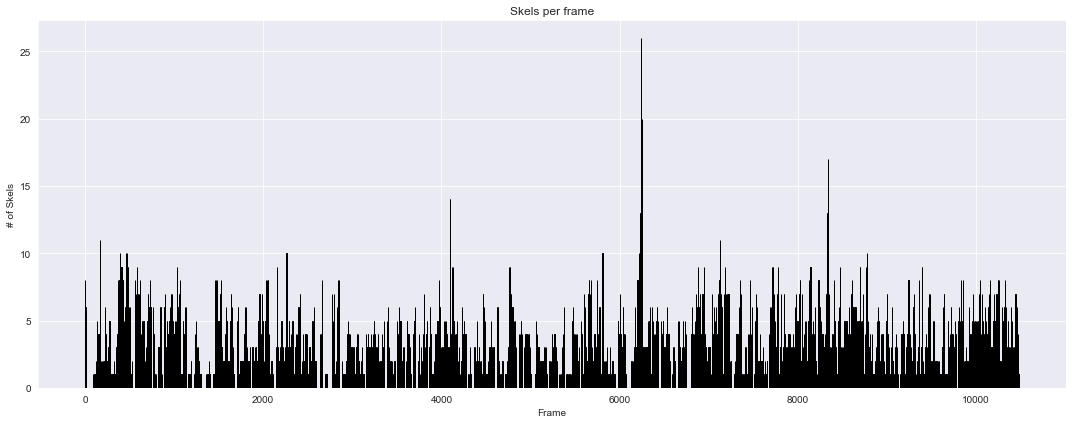

In [21]:
# ALTERNATIVA AO BAR PLOT - RECORRER DIRETAMENTE A UM HISTOGRAMA:

# note, each bin is defined by [n1, n2), that is, n1 is included and n2 excluded. 
# that is why the bins start at -0.5, so that the first one is defined by 
# [-0.5, 0.5), including the frame 0, which is intended. the same applies 
# to the other frames, each represented by each individual bin (there 
# exists has many bins as frames)
frames_skeletons = skel_data[0, :]

plt.figure(figsize=(15, 6), tight_layout=True)
plt.hist(frames_skeletons, bins=np.arange(-0.5, features.shape[1] + 0.5), edgecolor='black')
plt.title('Skels per frame')
plt.xlabel('Frame')
plt.ylabel('# of Skels')
plt.show()

True

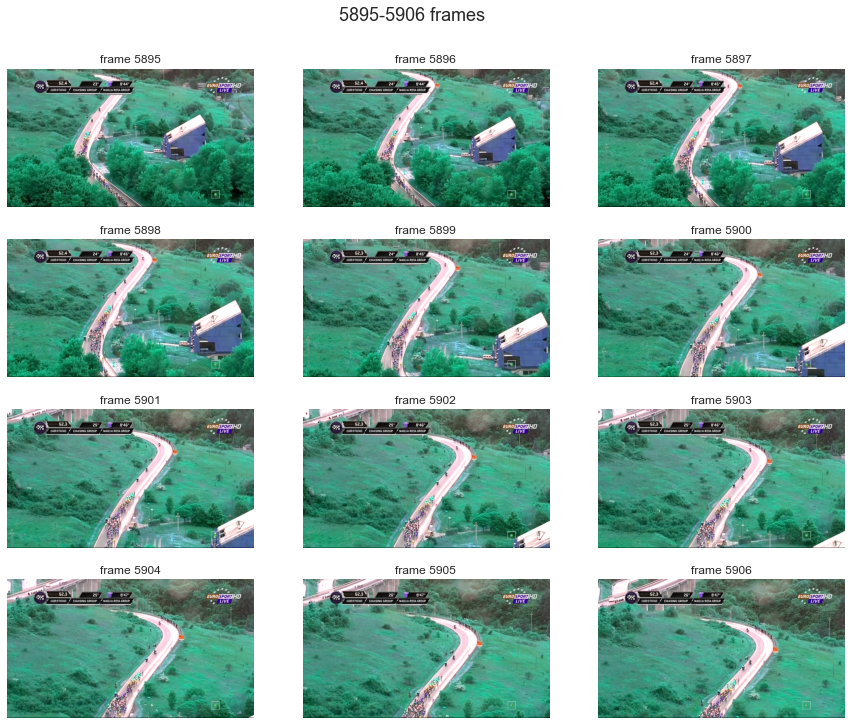

In [22]:
IMAGES_DIR = '../images/'
SAVE_IMAGES = False

opencv.extract_frames(VIDEO_FILE, LABELS, 4, 3, '{0}-{1} frames'.format(FROM_FRAME, TO_FRAME), SAVE_IMAGES, IMAGES_DIR)

In [23]:
basis_12subspace, sigma_12subspace, vT_12subspace = linear_subspaces.factorisation(subspace_vectors, 12)

factorisation_12base = (basis_12subspace, sigma_12subspace, vT_12subspace)

basis_12base_rank2, _, _ = linear_subspaces.reduce_factorisation_dimensions(factorisation_12base, 2)

#coefficients = np.diag(reduced_factorisation[1].flatten()) @ reduced_factorisation[2]
#coefficients_12base_rank2 = np.diag(reduced_factorisation_rank2[1]) @ reduced_factorisation_rank2[2]
coefficients_12base_rank2 = basis_12base_rank2.T @ subspace_vectors

Reducing original 12-dim factorisation to 2 dimensions...


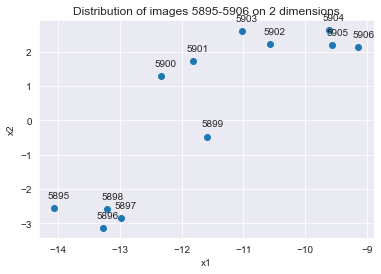

In [24]:
# coefficients = np.diag(sigma) .* (dot product) V_t
x1 = coefficients_12base_rank2[0]
x2 = coefficients_12base_rank2[1]

plt.title('Distribution of images {0}-{1} on 2 dimensions'.format(FROM_FRAME, TO_FRAME))
plt.scatter(x1, x2)
plt.xlabel('x1')
plt.ylabel('x2')

for x, y, label in zip(x1, x2, LABELS):
    plt.annotate(label,  # this is the text
                 (x, y),  # these are the coordinates to position the label
                 textcoords="offset points",  # how to position the text
                 xytext=(5, 10),  # distance from text to points (x,y)
                 ha='center')

plt.show()

In [25]:
basis_fulldataset, sigma_fulldataset, vT_fulldataset = linear_subspaces.factorisation(features, features.shape[1])

factorisation_fulldataset = (basis_fulldataset, sigma_fulldataset, vT_fulldataset)

basis_fulldataset_rank2, _, _ = linear_subspaces.reduce_factorisation_dimensions(factorisation_fulldataset, 2)

plotting.consecutive_frames_linkage(basis_fulldataset_rank2, features, VIDEO_FILE)

KeyboardInterrupt: 

In [26]:
coefficients_fulldataset_rank2 = basis_fulldataset_rank2.T @ features
#coefficients_fulldataset_rank2 = np.diag(reduced_factorisation_fulldataset[1]) @ reduced_factorisation_fulldataset[2]

x1 = coefficients_fulldataset_rank2[0]
x2 = coefficients_fulldataset_rank2[1]

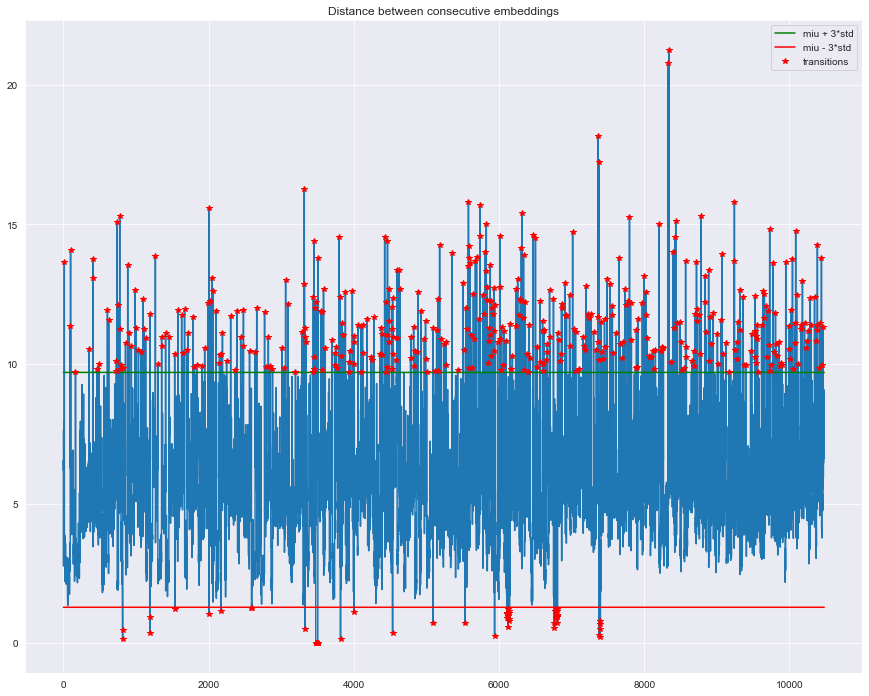

In [27]:
#TO DO: each point is one column of CT the the blue lines connect consecutive 
#images. Can you figure out where (most likely) the outliers are ?) - 
#check it ! ---> QUANDO O LINKAGE BETWEEN CONSECUTIVE IMAGES IS BIG 

#TO DO: And shot transitions?  plot each point at a time and visualize 
#the images !  

# NOTA: OS COEFICIENTES NAO DÁ IGUAL, MAS A SUA RELAÇÃO PARECE QUE SIM. 
# OS VALORES NOS EIXOS X E Y SÃO DIFERENTES DAQUELES QUE O PROF MOSTROU 
# NA SOLUÇÃO 

d, segment_frames = plotting.consecutive_frames_distance(features)

segments = [(segment_frames[i], segment_frames[i + 1])
            for i in range(0, len(segment_frames) - 1, 2)]

In [28]:
opencv.display_segments(VIDEO_FILE, segment_frames)

KeyboardInterrupt: 

<Figure size 1080x864 with 0 Axes>

In [29]:
rank_90representativity = plotting.sigularvalues(sigma_fulldataset)

rank_90representativity = rank_90representativity[0]
#Several criteria for the rank (to be discussed later): 1) you know the 
#variance of the noise, 2)90% of the “energy” (value of k when the 
#blue curve is 0.1) 3) “hunch” 😑 - when the singular values “flatten” 
#(fig s1)

We can get 90.072% representativity with 365 singular values.


In [ ]:
#TENTEI INTEGRAR NA FUNÇÃO plotting.sigularvalues

sigma = sigma_12subspace

representativity = linear_subspaces.get_representativity(sigma)

print('Singular Values: ', sigma)
print('Representativity: ', representativity)

# pick the first i singular values such that representativity(sigma) > 0.9 - rank-i approximation
# basically select the least number of vectors of U U^T such that represent the picked images with 90% accuracy
# plot i = {1 ... size(sigma)} vs representativity with matplotlib - should give a graph similar to a person's elbow
# trace a line in the plot marking the 0.9 threshold
THRESHOLD = 0.9

min_repr = linear_subspaces.minimum_representativity(representativity, THRESHOLD)

sigma_min_repr = linear_subspaces.get_singular_value(sigma, min_repr)

small_dataset_rank = plotting.sigularvalues(sigma)

In [ ]:
basis = basis_12subspace
projector, null_projector = linear_subspaces.get_basis_projectors(basis)

In [ ]:
top_projections = 100
(norm_proj, norm_orth_proj), (idx_larger_projnorm, idx_larger_orthprojnorm) = linear_subspaces.compare_projections(
        basis, features, top_projections)

In [ ]:
print('{0} images whose projection on the subspace have got larger norm:\n'.format(top_projections),
      idx_larger_projnorm)
opencv.extract_frames(VIDEO_FILE, idx_larger_projnorm, 10, 10, 'projection on the subspace of rank = 12', SAVE_IMAGES,
                      IMAGES_DIR)

In [ ]:
print('{0} images whose projection on its kernel (null) have got larger norm:\n'.format(top_projections),
      idx_larger_orthprojnorm)
opencv.extract_frames(VIDEO_FILE, idx_larger_orthprojnorm, 10, 10,
                      'projection on the null in relation to the subspace of rank = 12', SAVE_IMAGES, IMAGES_DIR)

### Reduce the number of images in the base (from 12 down to 3 !). What do you observe?

In [ ]:
# Reduce the number of images in the base (from 12 down to 3 !). What do you observe?
rank = 3
basis_12base_rank3, _, _ = linear_subspaces.reduce_factorisation_dimensions(factorisation_12base, rank)

(norm_proj_short, norm_orth_proj_short),
(idx_larger_projnorm_short, idx_larger_orthprojnorm_short) = linear_subspaces.compare_projections(basis_12base_rank3,
                                                                                                  features,
                                                                                                  top_projections)

In [ ]:
print('{0} images whose projection on the reduced subspace have got larger norm:\n'.format(top_projections),
      idx_larger_projnorm_short)
opencv.extract_frames(VIDEO_FILE, idx_larger_projnorm_short, 10, 10, 'projection on the subspace of rank = 3',
                      SAVE_IMAGES, IMAGES_DIR)

In [ ]:
print('{0} images whose projection on its kernel (null) have got larger norm:\n'.format(top_projections),
      idx_larger_orthprojnorm_short)
opencv.extract_frames(VIDEO_FILE, idx_larger_orthprojnorm_short, 10, 10,
                      'projection on the null in relation to the subspace of rank = 3', SAVE_IMAGES, IMAGES_DIR)

In [ ]:
print('There are {0} out of {1} common elements between the largest norms on the subspace.'.format(
        np.intersect1d(idx_larger_projnorm, idx_larger_projnorm_short).size, top_projections))
print('There are {0} out of {1} common elements between the largest norms on the null subspace.'.format(
        np.intersect1d(idx_larger_orthprojnorm, idx_larger_orthprojnorm_short).size, top_projections))

### Getting reduced basis with 90% representativity

In [ ]:
rank = small_dataset_rank  # 8 (in principle - see graph above)
basis_12base_rank8, _, _ = linear_subspaces.reduce_factorisation_dimensions(factorisation_12base, rank)

(norm_proj_short8, norm_orth_proj_short8),
(idx_larger_projnorm_short8, idx_larger_orthprojnorm_short8) = linear_subspaces.compare_projections(basis_12base_rank8,
                                                                                                    features,
                                                                                                    top_projections)

In [ ]:
top_projections = 100
(norm_proj, norm_orth_proj), (idx_larger_projnorm, idx_larger_orthprojnorm) = linear_subspaces.compare_projections(
        basis_fulldataset, features, top_projections)

In [ ]:
print('{0} images whose projection on the subspace have got larger norm:\n'.format(top_projections),
      idx_larger_projnorm)
opencv.extract_frames(VIDEO_FILE, idx_larger_projnorm, 10, 10, 'projection on the subspace of rank = 12', SAVE_IMAGES)

In [ ]:
print('{0} images whose projection on its kernel (null) have got larger norm:\n'.format(top_projections),
      idx_larger_orthprojnorm)
opencv.extract_frames(VIDEO_FILE, idx_larger_orthprojnorm, 10, 10,
                      'projection on the null in relation to the subspace of rank = 12', SAVE_IMAGES)

### Getting reduced basis with 90% representativity

In [ ]:
basis_90representativity, _, _ = linear_subspaces.reduce_factorisation_dimensions(factorisation_fulldataset,
                                                                                  rank_90representativity)

(norm_proj_90representativity, norm_orth_proj_90representativity),
(idx_larger_projnorm_90representativity,
 idx_larger_orthprojnorm_90representativity) = linear_subspaces.compare_projections(basis_90representativity, features,
                                                                                    top_projections)

In [ ]:
print('{0} images whose projection on the subspace have got larger norm:\n'.format(top_projections),
      idx_larger_projnorm)
opencv.extract_frames(VIDEO_FILE, idx_larger_projnorm_90representativity, 10, 10,
                      'projection on the subspace of rank = 12', SAVE_IMAGES)

In [ ]:
print('{0} images whose projection on its kernel (null) have got larger norm:\n'.format(top_projections),
      idx_larger_orthprojnorm)
opencv.extract_frames(VIDEO_FILE, idx_larger_orthprojnorm_90representativity, 10, 10,
                      'projection on the null in relation to the subspace of rank = 12', SAVE_IMAGES)

In [ ]:
print('There are {0} out of {1} common elements between the largest norms on the subspace.'.format(
        np.intersect1d(idx_larger_projnorm, idx_larger_projnorm_90representativity).size, top_projections))
print('There are {0} out of {1} common elements between the largest norms on the null subspace.'.format(
        np.intersect1d(idx_larger_orthprojnorm, idx_larger_orthprojnorm_90representativity).size, top_projections))

### Rank = 10 and rank = 100

In [ ]:
rank = 100
basis_rank100, _, _ = linear_subspaces.reduce_factorisation_dimensions(factorisation_fulldataset, rank)

(norm_proj_rank100, norm_orth_proj_rank100),
(idx_larger_projnorm_rank100, idx_larger_orthprojnorm_rank100) = linear_subspaces.compare_projections(basis_rank100,
                                                                                                      features,
                                                                                                      top_projections)

In [ ]:
rank10 = 10
basis_rank10, _, _ = linear_subspaces.reduce_factorisation_dimensions(factorisation_fulldataset, rank10)

(norm_proj_rank10, norm_orth_proj_rank10),
(idx_larger_projnorm_rank10, idx_larger_orthprojnorm_rank10) = linear_subspaces.compare_projections(basis_rank10,
                                                                                                    features,
                                                                                                    top_projections)

### Outliers

In [ ]:
def bins(num_samples):
    return num_samples ** (1 / 2)


num_bins = round(bins(features.shape[1]))

plt.figure(figsize=(8, 6))
plt.hist(norm_orth_proj_90representativity, bins=np.linspace(0, 1, num_bins), alpha=0.5,
         label='rank = {0}'.format(rank_90representativity))
plt.hist(norm_orth_proj_rank100, bins=np.linspace(0, 1, num_bins), alpha=0.5, label='rank = {0}'.format(rank))
plt.hist(norm_orth_proj_rank10, bins=np.linspace(0, 1, num_bins), alpha=0.5, label='rank = {0}'.format(rank10))
plt.legend(loc='upper right')
plt.xlabel("Histogram of the norm in the null subspace", size=14)
plt.ylabel("Count", size=14)

outliers_100 = np.argwhere(norm_orth_proj_rank100 > 0.7)
outliers_10 = np.argwhere(norm_orth_proj_rank10 > 0.7)

plt.figure(figsize=(8, 6))
plt.plot(norm_orth_proj_rank100)
plt.plot(outliers_100, norm_orth_proj_rank100[outliers_100], 'r*', label='outliers')
plt.legend(loc='lower right')
plt.title('Norm of the images in the null subspace, rank = {0}'.format(rank10))
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(norm_orth_proj_rank10)
plt.plot(outliers_10, norm_orth_proj_rank10[outliers_10], 'r*', label='outliers')
plt.legend(loc='lower right')
plt.title('Norm of the images in the null subspace, rank = {0}'.format(rank10))
plt.show()

plt.figure(figsize=(8, 6))
plt.title('Distribution of full dataset of dimension {0} on rank = 2 subspace'.format(features.shape[0]))
plt.plot(x1, x2, 'b.')
plt.plot(x1[outliers_100], x2[outliers_100], 'r*', label='outliers')
plt.legend(loc='upper right')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

plt.figure(figsize=(8, 6))
plt.title('Distribution of full dataset of dimension {0} on rank = 2 subspace'.format(features.shape[0]))
plt.plot(x1, x2, 'b.')
plt.plot(x1[outliers_10], x2[outliers_10], 'r*', label='outliers')
plt.legend(loc='upper right')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [ ]:
opencv.interactive_outlier_display(VIDEO_FILE, features, norm_orth_proj_rank10, outliers_10.flatten())

In [ ]:
best_fit, outliers_ransac = data_preprocessing.RANSAC(features, rank=10, t=0.85)

In [ ]:
best_base = best_fit[0]

(norm_proj_best, norm_orth_proj_best),
(_, _) = linear_subspaces.compare_projections(best_base, features, top_projections)

plt.figure(figsize=(8, 6))
plt.hist(norm_orth_proj_best, bins=np.linspace(0, 1, num_bins), alpha=0.5)
plt.show()

plt.figure(figsize=(8, 6))
plt.title('Distribution of full dataset of dimension {0} on rank = 2 subspace'.format(features.shape[0]))
plt.plot(x1, x2, 'b.')
plt.plot(x1[outliers_ransac], x2[outliers_ransac], 'r*', label='outliers')
plt.legend(loc='upper right')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [ ]:
opencv.interactive_outlier_display(VIDEO_FILE, features, norm_orth_proj_best, outliers_ransac.flatten())

### Remove outliers

In [ ]:
features_no_outliers = np.delete(features, outliers_ransac, axis=1)

print(features_no_outliers.shape)
print(features.shape)

### KNN and Sparse Graph

In [ ]:
_, g_sparse_matrix = graph.knnregressor(features, features, 13)

In [ ]:
graph.draw_adjacency_graph(g_sparse_matrix)

In [ ]:
graphs.draw_adjacency_graph(g_sparse_matrix, clustering='True')

### Clustering 

In [ ]:
coefs, centres, labels, idx_features = clustering.kmeans_clustering(features, 100, n_clusters=20)

In [ ]:
tsne_features = clustering.tsne(coefs)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))
sc = ax.scatter(tsne_features[:, 0], tsne_features[:, 1], c=idx_features, alpha=0.7, cmap='tab10')
ax.legend(*sc.legend_elements(), title='clusters')

plt.gca().set_aspect('equal', adjustable='box')
plt.title('Clustering of the frames')

plt.show()

### Treating the skeletons.

In [ ]:
SKELETONS_FILE = DATASET_DIR + 'esqueletosveryslow_complete.mat'
skel_data = load_data(SKELETONS_FILE)
complete_skeletons, dev_complete = data_preprocessing.get_features(skel_data, 'skeldata', FROM_FRAME, TO_FRAME)

# skeletons: tuple of size 2:
# first element of tuple:
# nd array (55, 20793)
# perhaps for the whole film
# 20 793 detected poses
# test on this one after developing with the one below
# sencond element of tuple:
# nd array (55,12)
# frames [2934. 2935. 2935. 2935. 2936. 2936. 2937. 2937. 2937. 2938. 2938. 2939.]
# 12 detected poses
# use this one for development

# first line of each array contains the frame number for the skeleton
# each matrix is 55 x number of detected poses
# each column, when extracted the first line (which indicates the corresponding image), is composed by 54 values:
# 54 / 3 = 18 triplets (xi, yi, pi)

# doubt: is the missing data the zeros in each column?
# doubt: how do we use the probability of each joint?

skel_dev = skeletons.extract_skeletons(dev_complete, 2935)[0]

In [ ]:
def center_data(data, mean):
    return data - mean


skeletons_x = skeletons.skeletons_x(complete_skeletons)
skeletons_y = skeletons.skeletons_y(complete_skeletons)

skeletons_x_mean = np.mean(skeletons_x, axis=0).reshape(1, -1)
skeletons_y_mean = np.mean(skeletons_y, axis=0).reshape(1, -1)

assert skeletons_x_mean.shape[1] == complete_skeletons.shape[1]
assert skeletons_y_mean.shape[1] == complete_skeletons.shape[1]

skeletons_x_centered = data_preprocessing.center_data(skeletons_x, skeletons_x_mean)
skeletons_y_centered = data_preprocessing.center_data(skeletons_y, skeletons_y_mean)

In [ ]:
skeletons_dev_x = skeletons.skeletons_x(dev_complete)
skeletons_dev_y = skeletons.skeletons_y(dev_complete)

skeletons_dev_x_mean = np.mean(skeletons_dev_x, axis=0).reshape(1, -1)
skeletons_dev_y_mean = np.mean(skeletons_dev_y, axis=0).reshape(1, -1)

assert skeletons_dev_x_mean.shape[1] == dev_complete.shape[1]
assert skeletons_dev_y_mean.shape[1] == dev_complete.shape[1]

skeletons_dev_x_centered = center_data(skeletons_dev_x, skeletons_dev_x_mean)
skeletons_dev_y_centered = center_data(skeletons_dev_y, skeletons_dev_y_mean)

#ESTAS FUNÇÕES JÁ NAO EXISTEM
# - draw single skeleton
#skeletons.draw_poses(skeletons_x[:, 1][:, None], skeletons_y[:, 1][:, None])
#skeletons.draw_poses(skeletons_x_centered[:, 1][:, None], skeletons_y_centered[:, 1][:, None])

#skeletons.draw_poses(skeletons_dev_x, skeletons_dev_y)
#skeletons.draw_poses(skeletons_dev_x_centered, skeletons_dev_y_centered, 'Skeletons centered')

In [ ]:
SKELETONS_INCOMPLETE = SKELETONS_FILE.replace('_complete', '')
skel_data_incomplete = load_data(SKELETONS_INCOMPLETE)
skeletons_incomplete, dev_incomplete = data_preprocessing.get_features(skel_data_incomplete, 'skeldata', FROM_FRAME,
                                                                       TO_FRAME)

In [ ]:
opencv.skeletons_frames_overlap(VIDEO_FILE, (complete_skeletons,), np.arange(0, features.shape[1]), display='processed',
                                write_video=False)

In [ ]:
plotting.heatmap_example()

In [ ]:
differences, different_columns, equal_columns, different_rows, equal_rows, percentage = data_preprocessing.find_missing_data(
        dev_incomplete)

### Histogram of missing joints 

(estou a tentar obter o histogram que o prof poe neste link: https://jpcosteira.notion.site/LabClasses-6a4b3f97592e4f3b8eabe8e9f9dfa08f -number of missing coordinates) 
visto que no eixo dos x está de 0 a cerca de 18, fiquei a achar que pudesse ser a joints. 

In [ ]:
incomplete_x_coordinates = differences[1::3, :]

incomplete_y_coordinates = differences[2::3, :]

bool_joints = incomplete_x_coordinates + incomplete_y_coordinates

joints_matrix = np.repeat(np.arange(1, 19)[:, None], bool_joints.shape[1], axis=1)

incomplete_joints = (joints_matrix * bool_joints.astype(int)).reshape(-1, 1)

#print(incomplete_joints[incomplete_joints != 0])

plt.figure(figsize=(8, 6))
plt.hist(incomplete_joints[incomplete_joints != 0], bins=np.arange(0.5, 19.5), edgecolor='black')
plt.show()

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 10))
heat_map = sns.heatmap(differences, linewidth=1, annot=True, xticklabels=dev_complete[0].astype(int))
plt.title('Missing Data Pattern')
plt.xlabel('Frame', size=14)
plt.ylabel('Feature', size=14)
plt.show()

In [ ]:
incomplete_skeletons_dev = dev_incomplete[1:]
#incomplete_skeletons_dev = np.array([[0,2,0,7,6,2], [4,5,0,6,6,1], [5,6,1,5,3,2], [5,1,4,2,6,2], [1,4,7,3,8,7]])

TOLERANCE = 0.90
MAX_ITERATIONS = 10000

ranks = np.arange(2, incomplete_skeletons_dev.shape[1] + 1)
errors = []

plt.figure()
for rank in ranks:
    approximation, error = data_preprocessing.complete_missing_data(incomplete_skeletons_dev, rank, TOLERANCE,
                                                                    MAX_ITERATIONS)

    errors = np.append(errors, error)

plt.ylabel('1 - error')
plt.xlabel('rank')
plt.plot(ranks, errors, '*-')
plt.show()

mask = differences.astype(int)[1:]
opposite_mask = (np.ones_like(mask) - mask)

reference_imputation = dev_complete[1:]

print(
        '\nComparison between the algorithm conceived and the one that will be taken as reference (not ground truth altough):')
print('- Error of the visible data is {0:.11g}.'.format(
        np.linalg.norm(mask * (reference_imputation - approximation), 'fro')))
print('- Error of the missing data imputaion is {0:.11g}.'.format(
        np.linalg.norm(opposite_mask * (reference_imputation - approximation), 'fro')))
print('- Error of the whole data is {0:.11g}.'.format(np.linalg.norm(reference_imputation - approximation, 'fro')))

In [ ]:
approximation, error = data_preprocessing.complete_missing_data(incomplete_skeletons_dev, 4, TOLERANCE, MAX_ITERATIONS)

In [ ]:
skel_data_dev_comparison = (dev_incomplete, dev_complete, np.append(dev_complete[0, :][None, :], approximation, axis=0))

In [ ]:
opencv.skeletons_frames_overlap(VIDEO_FILE, skel_data_dev_comparison, dev_complete[0, :].astype(int), fps=1,
                                display='reconstructed', title_list=['incomplete', 'complete', 'reconstructed'],
                                write_video=False)

### Stacking the skeletons and images 

In [ ]:
stacked_matrix_incomplete = data_preprocessing.dataset_stacking(skeletons_incomplete, features)